*ref: https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html*

In [2]:
#We will first load the entire adult census dataset.

import pandas as pd

adult_census = pd.read_csv("../../datasets/adult-census.csv")
# drop the duplicated column `"education-num"` as stated in the first notebook
adult_census = adult_census.drop(columns="education-num")

target_name = "class"
target = adult_census[target_name]

data = adult_census.drop(columns=[target_name])

# Selection based on data types

In [3]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [5]:
numerical_columns

['age', 'capital-gain', 'capital-loss', 'hours-per-week']

In [6]:
categorical_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

# Dispatch columns to a specific processor

Scikit-learn provides a ColumnTransformer class which will send specific columns to a specific transformer, making it easy to fit a single predictive model on a dataset that combines both kinds of variables together (heterogeneously typed tabular data).

We first define the columns depending on their data type:

- one-hot encoding will be applied to categorical columns. Besides, we use handle_unknown="ignore" to solve the potential issues due to rare categories.
- numerical scaling numerical features which will be standardized.

In [9]:
#First, let’s create the preprocessors for the numerical and categorical parts.

from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [10]:
# Now, we create the transformer and associate each of these preprocessors with their respective columns.

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

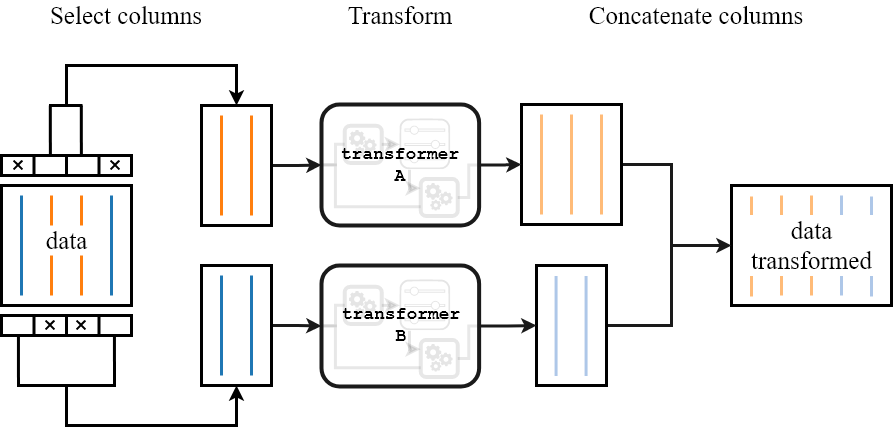

A ColumnTransformer does the following:
- It splits the columns of the original dataset based on the column names or indices provided. We will obtain as many subsets as the number of transformers passed into the ColumnTransformer.
- It transforms each subsets. A specific transformer is applied to each subset: it will internally call fit_transform or transform. The output of this step is a set of transformed datasets.
- It then concatenates the transformed datasets into a single dataset.

In [11]:
# It can be combined with a classifier in a Pipeline:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

The final model is more complex than the previous models but still follows the same API (the same set of methods that can be called by the user):

- the **fit** method is called to preprocess the data and then train the classifier of the preprocessed data;
- the **predict** method makes predictions on new data;
- the **score** method is used to predict on the test data and compare the predictions to the expected test labels to compute the accuracy.

In [12]:
# Let’s start by splitting our data into train and test sets.

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

In [13]:
# Now, we can train the model on the train set.

_ = model.fit(data_train, target_train)

In [14]:
# Then, we can send the raw dataset straight to the pipeline. 
# Indeed, we do not need to make any manual preprocessing 
# (calling the transform or fit_transform methods) as it will be handled when calling the predict method. 
# As an example, we predict on the five first samples from the test set.

data_test.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
7762,56,Private,HS-grad,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States
23881,25,Private,HS-grad,Married-civ-spouse,Transport-moving,Own-child,Other,Male,0,0,40,United-States
30507,43,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,14344,0,40,United-States
28911,32,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
19484,39,Private,Bachelors,Married-civ-spouse,Sales,Wife,White,Female,0,0,30,United-States


In [15]:
model.predict(data_test)[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

In [16]:
target_test[:5]

7762      <=50K
23881     <=50K
30507      >50K
28911     <=50K
19484     <=50K
Name: class, dtype: object

In [17]:
# To get directly the accuracy score, we need to call the score method. 
# Let’s compute the accuracy score on the entire test set.

model.score(data_test, target_test)

0.8576693145524527

# Evaluation of the model with cross-validation

In [18]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=5)
cv_results

{'fit_time': array([2.01168299, 1.99189758, 2.20259881, 2.24269581, 2.36554956]),
 'score_time': array([0.08041739, 0.07262015, 0.0900774 , 0.08722854, 0.08489418]),
 'test_score': array([0.8512642 , 0.84993346, 0.84756347, 0.8523751 , 0.85513923])}

In [19]:
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean cross-validation accuracy is: 0.851 ± 0.003


# Fitting a more powerful model
Linear models are nice because they are usually cheap to train, small to deploy, fast to predict and give a good baseline.

However, it is often useful to check whether more complex models such as an ensemble of decision trees can lead to higher predictive performance. In this section we will use such a model called gradient-boosting trees and evaluate its generalization performance. 

For tree-based models, the handling of numerical and categorical variables is simpler than for linear models:
- we do not need to scale the numerical features
- using an ordinal encoding for the categorical variables is fine even if the encoding results in an arbitrary ordering

Therefore, for HistGradientBoostingClassifier, the preprocessing pipeline is slightly simpler than the one we saw earlier for the LogisticRegression:

In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('categorical', categorical_preprocessor, categorical_columns)],
    remainder="passthrough")

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())

In [27]:
%%time

# Now that we created our model, we can check its generalization performance.

_ = model.fit(data_train, target_train)

CPU times: total: 9.41 s
Wall time: 2.82 s


In [28]:
model.score(data_test, target_test)

0.8792891655065105